# 1. Libraries 

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA

from pyod.models.iforest import IForest
from pyod.models.pca import PCA

from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_score, recall_score

import tensorflow as tf

import seaborn as sns
sns.set_style('white')

import warnings
warnings.filterwarnings(action='ignore')

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [8]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print(tf.config.list_physical_devices('GPU'))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9524066475336480040
xla_global_id: -1
]
[]


In [9]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = '0' # 여러개 사용시 '0,1,2' 식으로 하나의 문자열에 입력
gpus = tf.config.experimental.list_physical_devices('GPU') # 호스트 러나임에 표시되는 GPU 장치 목록 반환

if gpus: # 반환된 GPU 장치 목록이 있다면
    try: # 해당 장치에 대한 메모리 증가 활성화 여부 설정
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e: # try문 실패시에 에러문구 출력
        print(e)

In [93]:
path = "./Dataset/"

dataT = pd.read_csv(path+"train_T.csv")  
dataO = pd.read_csv(path+"train_O.csv")  

# original data -> data
data = pd.concat([dataT, dataO]).reset_index(drop=True)
data

,Y_Class,Y_Quality,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,...,X_3317,X_3318,X_3319,X_3320,X_3321,X_3322,X_3323,X_3324,X_3325,X_3326
0,1,0.531957,T100304,T_31,2.0,95.0,0.0,45.0,10.0,0.0,...,0.000008,0.000003,0.191408,0.000008,0.001210,0.000021,0.000003,0.000002,0.189,0.000006
1,1,0.531105,T100306,T_31,2.0,96.0,0.0,45.0,10.0,0.0,...,0.000008,0.000003,0.188993,0.000032,0.000644,0.000041,0.000002,0.000003,0.185,0.000029
2,1,0.532292,T100306,T_31,2.0,95.0,0.0,45.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,0.528141,T100306,T_31,2.0,87.0,0.0,45.0,10.0,0.0,...,0.000007,0.000003,0.189424,0.000034,0.000678,0.000043,0.000004,0.000003,0.188,0.000031
4,1,0.532289,T100306,T_31,2.0,95.0,0.0,45.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
833,1,0.529740,T100304,O_31,154.0,97.0,0.0,45.0,11.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
834,1,0.532343,T100306,O_31,146.0,94.0,0.0,45.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
835,1,0.530533,T100304,O_31,4.0,98.0,0.0,45.0,11.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
836,2,0.535205,T100306,O_31,6.0,89.0,0.0,45.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 2. Preprocessing

1. 같은 값으로만 채워진 column 삭제 (nunique(dropna=False) <= 1) 
2. 모든 행이 같은 값을 가지는 두 개 이상의 중복된 column 삭제 
3. 결측치 처리 (KNN Imputetor, fillna(0))
4. 정규화 (Robust, MinMax, Standard)
5. 카테고리 변수 수치화 (LINE, PRODUCT_CODE) LabelEncoder

In [106]:
# 1. 같은 값으로만 채워진 column 삭제 (nunique(dropna=False) <= 1)
# Get the counts of unique values per column
value_counts = data.iloc[:,4:].apply(lambda x: x.nunique(dropna=False))

# Filter columns with only one unique value
unique_columns = value_counts[value_counts >= 2].index
duplicated_columns = value_counts[value_counts <= 1].index

# Preprocessed data -> processed_data
processed_data = data.drop(duplicated_columns, axis=1)
processed_data

,Y_Class,Y_Quality,LINE,PRODUCT_CODE,X_1,X_2,X_4,X_5,X_7,X_8,...,X_3317,X_3318,X_3319,X_3320,X_3321,X_3322,X_3323,X_3324,X_3325,X_3326
0,1,0.531957,T100304,T_31,2.0,95.0,45.0,10.0,45.0,10.0,...,0.000008,0.000003,0.191408,0.000008,0.001210,0.000021,0.000003,0.000002,0.189,0.000006
1,1,0.531105,T100306,T_31,2.0,96.0,45.0,10.0,53.0,10.0,...,0.000008,0.000003,0.188993,0.000032,0.000644,0.000041,0.000002,0.000003,0.185,0.000029
2,1,0.532292,T100306,T_31,2.0,95.0,45.0,10.0,60.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,0.528141,T100306,T_31,2.0,87.0,45.0,10.0,53.0,10.0,...,0.000007,0.000003,0.189424,0.000034,0.000678,0.000043,0.000004,0.000003,0.188,0.000031
4,1,0.532289,T100306,T_31,2.0,95.0,45.0,10.0,51.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
833,1,0.529740,T100304,O_31,154.0,97.0,45.0,11.0,45.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
834,1,0.532343,T100306,O_31,146.0,94.0,45.0,10.0,67.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
835,1,0.530533,T100304,O_31,4.0,98.0,45.0,11.0,45.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
836,2,0.535205,T100306,O_31,6.0,89.0,45.0,10.0,51.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [107]:
# 2. 모든 행이 같은 값을 가지는 두 개 이상의 중복된 column 삭제
df = processed_data.iloc[:,4:].T.drop_duplicates(keep='first').T
processed_data = pd.concat([processed_data.iloc[:,:4], df], axis=1)
processed_data

,Y_Class,Y_Quality,LINE,PRODUCT_CODE,X_1,X_2,X_4,X_5,X_7,X_8,...,X_3317,X_3318,X_3319,X_3320,X_3321,X_3322,X_3323,X_3324,X_3325,X_3326
0,1,0.531957,T100304,T_31,2.0,95.0,45.0,10.0,45.0,10.0,...,0.000008,0.000003,0.191408,0.000008,0.001210,0.000021,0.000003,0.000002,0.189,0.000006
1,1,0.531105,T100306,T_31,2.0,96.0,45.0,10.0,53.0,10.0,...,0.000008,0.000003,0.188993,0.000032,0.000644,0.000041,0.000002,0.000003,0.185,0.000029
2,1,0.532292,T100306,T_31,2.0,95.0,45.0,10.0,60.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,0.528141,T100306,T_31,2.0,87.0,45.0,10.0,53.0,10.0,...,0.000007,0.000003,0.189424,0.000034,0.000678,0.000043,0.000004,0.000003,0.188,0.000031
4,1,0.532289,T100306,T_31,2.0,95.0,45.0,10.0,51.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
833,1,0.529740,T100304,O_31,154.0,97.0,45.0,11.0,45.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
834,1,0.532343,T100306,O_31,146.0,94.0,45.0,10.0,67.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
835,1,0.530533,T100304,O_31,4.0,98.0,45.0,11.0,45.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
836,2,0.535205,T100306,O_31,6.0,89.0,45.0,10.0,51.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [108]:
# 3. Handling missing values  
processed_data = processed_data.fillna(0)
processed_data

,Y_Class,Y_Quality,LINE,PRODUCT_CODE,X_1,X_2,X_4,X_5,X_7,X_8,...,X_3317,X_3318,X_3319,X_3320,X_3321,X_3322,X_3323,X_3324,X_3325,X_3326
0,1,0.531957,T100304,T_31,2.0,95.0,45.0,10.0,45.0,10.0,...,0.000008,0.000003,0.191408,0.000008,0.001210,0.000021,0.000003,0.000002,0.189,0.000006
1,1,0.531105,T100306,T_31,2.0,96.0,45.0,10.0,53.0,10.0,...,0.000008,0.000003,0.188993,0.000032,0.000644,0.000041,0.000002,0.000003,0.185,0.000029
2,1,0.532292,T100306,T_31,2.0,95.0,45.0,10.0,60.0,10.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
3,1,0.528141,T100306,T_31,2.0,87.0,45.0,10.0,53.0,10.0,...,0.000007,0.000003,0.189424,0.000034,0.000678,0.000043,0.000004,0.000003,0.188,0.000031
4,1,0.532289,T100306,T_31,2.0,95.0,45.0,10.0,51.0,10.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
833,1,0.529740,T100304,O_31,154.0,97.0,45.0,11.0,45.0,10.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
834,1,0.532343,T100306,O_31,146.0,94.0,45.0,10.0,67.0,11.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
835,1,0.530533,T100304,O_31,4.0,98.0,45.0,11.0,45.0,10.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
836,2,0.535205,T100306,O_31,6.0,89.0,45.0,10.0,51.0,10.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000


In [109]:
# 4. Regularization 
transformer = RobustScaler()
processed_data.iloc[:, 4:] = transformer.fit_transform(processed_data.iloc[:, 4:])
processed_data

,Y_Class,Y_Quality,LINE,PRODUCT_CODE,X_1,X_2,X_4,X_5,X_7,X_8,...,X_3317,X_3318,X_3319,X_3320,X_3321,X_3322,X_3323,X_3324,X_3325,X_3326
0,1,0.531957,T100304,T_31,0.0,0.0,0.0,0.0,-0.833333,0.0,...,0.000008,0.000003,0.191408,0.000008,0.001210,0.000021,0.000003,0.000002,0.189,0.000006
1,1,0.531105,T100306,T_31,0.0,0.2,0.0,0.0,0.500000,0.0,...,0.000008,0.000003,0.188993,0.000032,0.000644,0.000041,0.000002,0.000003,0.185,0.000029
2,1,0.532292,T100306,T_31,0.0,0.0,0.0,0.0,1.666667,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
3,1,0.528141,T100306,T_31,0.0,-1.6,0.0,0.0,0.500000,0.0,...,0.000007,0.000003,0.189424,0.000034,0.000678,0.000043,0.000004,0.000003,0.188,0.000031
4,1,0.532289,T100306,T_31,0.0,0.0,0.0,0.0,0.166667,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
833,1,0.529740,T100304,O_31,152.0,0.4,0.0,1.0,-0.833333,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
834,1,0.532343,T100306,O_31,144.0,-0.2,0.0,0.0,2.833333,1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
835,1,0.530533,T100304,O_31,2.0,0.6,0.0,1.0,-0.833333,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
836,2,0.535205,T100306,O_31,4.0,-1.2,0.0,0.0,0.166667,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000


In [110]:
from sklearn.decomposition import PCA 

nonX_data = processed_data.iloc[:, :4]
X_data = processed_data.iloc[:, 4:]

pca = PCA(n_components=3)
pca_data = pca.fit_transform(X_data) 
pca_df = pd.DataFrame(pca_data, columns=['X1', 'X2', 'X3'])

processed_data = pd.concat([nonX_data, pca_df], axis=1)
processed_data

,Y_Class,Y_Quality,LINE,PRODUCT_CODE,X1,X2,X3
0,1,0.531957,T100304,T_31,16101.086813,-974.254424,-113.890426
1,1,0.531105,T100306,T_31,46349.903278,-1702.853292,172.964842
2,1,0.532292,T100306,T_31,-5094.754043,90.722540,-133.792450
3,1,0.528141,T100306,T_31,-3136.625768,-382.507494,-293.712963
4,1,0.532289,T100306,T_31,-5094.754110,90.722835,-133.793045
...,...,...,...,...,...,...,...
833,1,0.529740,T100304,O_31,-5094.760959,90.719835,-133.999758
834,1,0.532343,T100306,O_31,-5094.762151,90.722869,-134.045113
835,1,0.530533,T100304,O_31,-5094.753880,90.723373,-133.792056
836,2,0.535205,T100306,O_31,-5094.754097,90.722048,-133.788710


In [111]:
# 5. Label Encoding 
cat_cols = ['PRODUCT_CODE', 'LINE']

for col in cat_cols:
    le = LabelEncoder()
    processed_data[col] = le.fit_transform(processed_data[col])
    print(le.classes_)

processed_data.head()

['O_31' 'T_31']
['T100304' 'T100306']


,Y_Class,Y_Quality,LINE,PRODUCT_CODE,X1,X2,X3
0,1,0.531957,0,1,16101.086813,-974.254424,-113.890426
1,1,0.531105,1,1,46349.903278,-1702.853292,172.964842
2,1,0.532292,1,1,-5094.754043,90.722540,-133.792450
3,1,0.528141,1,1,-3136.625768,-382.507494,-293.712963
4,1,0.532289,1,1,-5094.754110,90.722835,-133.793045


# 3. Data Split

In [112]:
# Divide processed_data to abnormal and normal 
normal_data = processed_data[processed_data['Y_Class']==1]
normal_data['Y_Class'] = normal_data['Y_Class'].replace({1: 0}) # normal -> 0

undershoot = processed_data[processed_data['Y_Class']==0]
overshoot = processed_data[processed_data['Y_Class']==2]
abnormal_data = pd.concat([undershoot, overshoot])
abnormal_data['Y_Class'] = abnormal_data['Y_Class'].replace({2: 1, 0: 1}) # abnormal -> 1 

print('Normal Data:', normal_data.shape, ', Abnormal Data:', abnormal_data.shape)

# Create test data (normal 202, abnormal 202 = 404)
test_normal = normal_data.sample(n = 202, random_state = 42)
test_data = pd.concat([test_normal, abnormal_data])

# Create train data based on normal data (636 - 202 = 434)
train_normal = normal_data.drop(test_normal.index)

print('Train Normal Data:', train_normal.shape, ', Test Mixed Data:', test_data.shape)

#Divide data to X  data and y data 
train_y = train_normal['Y_Class']
train_X = train_normal.drop(['Y_Class'], axis=1)
test_y = test_data['Y_Class']
test_X = test_data.drop(['Y_Class'], axis=1)

print('Train X:', train_X.shape, ', Train y:', train_y.shape)
print('Test X:', test_X.shape, ', Test y:', test_y.shape, ', Test y value_countes: ', test_y.value_counts())

Normal Data: (636, 7) , Abnormal Data: (202, 7)
Train Normal Data: (434, 7) , Test Mixed Data: (404, 7)
Train X: (434, 6) , Train y: (434,)
Test X: (404, 6) , Test y: (404,) , Test y value_countes:  Y_Class
0    202
1    202
Name: count, dtype: int64


In [41]:
# Divide processed_data to input_data_X and input_data_y 
input_data_y = processed_data['Y_Class']
input_data_X = processed_data.drop(['Y_Class'], axis=1)

# train/ test data 로 split 
tr_val_X, test_X, tr_val_y, test_y = train_test_split(
    input_data_X, 
    input_data_y, 
    test_size = 0.2, 
    random_state = 42,
    shuffle=True,
    stratify = input_data_y # importnat
)

# valid/train 로 split
train_X, valid_X, train_y, valid_y = train_test_split(
    tr_val_X, 
    tr_val_y, 
    test_size = 0.2, 
    random_state = 42,
    shuffle=True,
    stratify = tr_val_y
)

print('X_train:', input_data_X.shape, 'y_train:', input_data_y.shape)
print('X_train:', train_X.shape, 'y_train:', train_y.shape)
print('X_valid:', valid_X.shape, 'y_train:', valid_y.shape)
print('X_test:', test_X.shape, 'y_train:', test_y.shape)

X_train: (838, 688) y_train: (838,)
X_train: (536, 688) y_train: (536,)
X_valid: (134, 688) y_train: (134,)
X_test: (168, 688) y_train: (168,)


# 4. Modeling 

1. Isolation Forest 
2. LOF (Local Outlier Factor)
3. PCA 
4. AutoEncoder 

In [114]:
# Isolation Forest 모델 구축
from pyod.models.iforest import IForest
IForest = IForest(random_state=SEED)
IForest.fit(train_X)

IForest(behaviour='old', bootstrap=False, contamination=0.1, max_features=1.0,
    max_samples='auto', n_estimators=100, n_jobs=1, random_state=42,
    verbose=0)

In [115]:
# train data에 대한 예측 값(정상=0, 이상=1)
IForest_train_pred = IForest.predict(train_X) 
IForest_train_pred

array([0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [116]:
# test data에 대한 예측 값(정상=1, 이상=-1)
IForest_test_pred = IForest.predict(test_X) 
IForest_test_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

accuracy:  0.5321782178217822
recall:  0.203
precision:  0.594
f1-score:  0.303


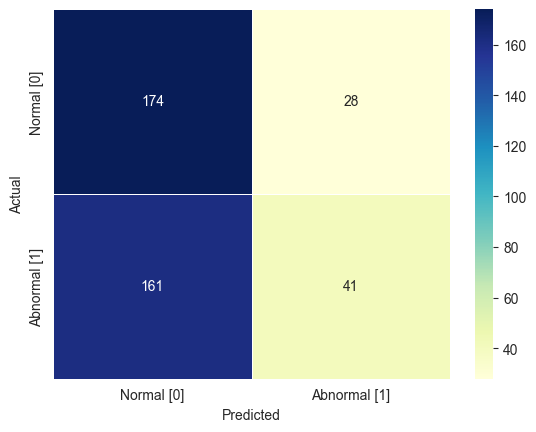

In [117]:
# Confusion matrix 출력 및 모델 성능 평가
# Isolation Forest는 기본적으로 이진분류에만 적용할 수 있으므로 y data 변환 
con_mat = confusion_matrix(test_y, IForest_test_pred)

sns.heatmap(pd.DataFrame(con_mat, columns = ['Predicted', 'Actual']),
            xticklabels=['Normal [0]', 'Abnormal [1]'], 
            yticklabels=['Normal [0]', 'Abnormal [1]'], 
            annot=True, fmt="d", linewidths=.5, cmap="YlGnBu")
plt.ylabel('Actual')
plt.xlabel('Predicted')

print("accuracy: ", accuracy_score(test_y, IForest_test_pred))
print("recall: ", round(recall_score(test_y, IForest_test_pred),3))
print("precision: ", round(precision_score(test_y, IForest_test_pred),3))
print("f1-score: ", round(f1_score(test_y, IForest_test_pred),3))

In [118]:
# LOF 모델 구축
from sklearn.neighbors import LocalOutlierFactor
LOF = LocalOutlierFactor(contamination=0.01, novelty=True)
LOF.fit(train_X)

LocalOutlierFactor(contamination=0.01, novelty=True)

In [119]:
# train data에 대한 예측 값(정상=1, 이상=-1)
LOF_train_pred = LOF.predict(train_X) 
LOF_train_pred

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1

In [120]:
# test data에 대한 예측 값(정상=1, 이상=-1)
LOF_test_pred = LOF.predict(test_X) 

LOF_test_pred = pd.DataFrame(LOF_test_pred)
LOF_test_pred = LOF_test_pred.replace({-1: 1, 1: 0})
LOF_test_pred

,0
0,0
1,0
2,0
3,0
4,0
...,...
399,0
400,0
401,0
402,0


accuracy:  0.4876237623762376
recall:  0.0
precision:  0.0
f1-score:  0.0


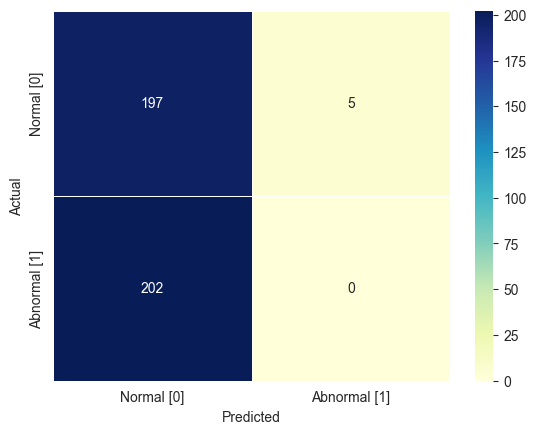

In [121]:
# Confusion matrix 출력 및 모델 성능 평가
con_mat = confusion_matrix(test_y, LOF_test_pred)

sns.heatmap(pd.DataFrame(con_mat, columns = ['Predicted', 'Actual']),
            xticklabels=['Normal [0]', 'Abnormal [1]'], 
            yticklabels=['Normal [0]', 'Abnormal [1]'], 
            annot=True, fmt="d", linewidths=.5, cmap="YlGnBu")
plt.ylabel('Actual')
plt.xlabel('Predicted')

print("accuracy: ", accuracy_score(test_y, LOF_test_pred))
print("recall: ", round(recall_score(test_y, LOF_test_pred),3))
print("precision: ", round(precision_score(test_y, LOF_test_pred),3))
print("f1-score: ", round(f1_score(test_y, LOF_test_pred),3))

In [122]:
from pyod.models.pca import PCA
PCA = PCA()
PCA.fit(train_X)

PCA(contamination=0.1, copy=True, iterated_power='auto', n_components=None,
  n_selected_components=None, random_state=None, standardization=True,
  svd_solver='auto', tol=0.0, weighted=True, whiten=False)

In [123]:
# train data에 대한 예측 값(정상=0, 이상=1)
PCA_train_pred = PCA.predict(train_X) 
PCA_train_pred

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [124]:
# train data에 대한 예측 값(정상=0, 이상=1)
PCA_test_pred = PCA.predict(test_X) 
PCA_test_pred

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1,

accuracy:  0.7524752475247525
recall:  0.629
precision:  0.836
f1-score:  0.718


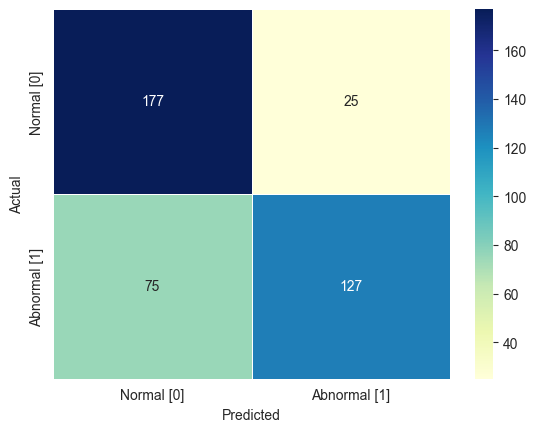

In [125]:
# Confusion matrix 출력 및 모델 성능 평가
con_mat = confusion_matrix(test_y, PCA_test_pred)

sns.heatmap(pd.DataFrame(con_mat, columns = ['Predicted', 'Actual']),
            xticklabels=['Normal [0]', 'Abnormal [1]'], 
            yticklabels=['Normal [0]', 'Abnormal [1]'], 
            annot=True, fmt="d", linewidths=.5, cmap="YlGnBu")
plt.ylabel('Actual')
plt.xlabel('Predicted')

print("accuracy: ", accuracy_score(test_y, PCA_test_pred))
print("recall: ", round(recall_score(test_y, PCA_test_pred),3))
print("precision: ", round(precision_score(test_y, PCA_test_pred),3))
print("f1-score: ", round(f1_score(test_y, PCA_test_pred),3))

In [126]:
# AutoEncoder
input_dim = train_X.shape[1]

AE = tf.keras.models.Sequential([
    
    # encode
    tf.keras.layers.Dense(input_dim, activation='elu', input_shape=(input_dim, )), 
    tf.keras.layers.Dense(4, activation='elu'),
    tf.keras.layers.Dense(2, activation='elu'),
    
    # decode
    tf.keras.layers.Dense(4, activation='elu'),
    tf.keras.layers.Dense(input_dim, activation='elu')
    
])

AE.compile(optimizer="adam", loss="mse")
AE.summary();

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 6)                 42        
                                                                 
 dense_6 (Dense)             (None, 4)                 28        
                                                                 
 dense_7 (Dense)             (None, 2)                 10        
                                                                 
 dense_8 (Dense)             (None, 4)                 12        
                                                                 
 dense_9 (Dense)             (None, 6)                 30        
                                                                 
Total params: 122
Trainable params: 122
Non-trainable params: 0
_________________________________________________________________


In [127]:
history = AE.fit(
    train_X,
    train_X,
    epochs=100,
    batch_size=32,
    validation_split=0.3
)

Epoch 1/100
10/10 [==============================] - 0s 15ms/step - loss: 21727214.0000 - val_loss: 26618266.0000
Epoch 2/100
10/10 [==============================] - 0s 4ms/step - loss: 21036036.0000 - val_loss: 25780018.0000
Epoch 3/100
10/10 [==============================] - 0s 4ms/step - loss: 20278364.0000 - val_loss: 24969242.0000
Epoch 4/100
10/10 [==============================] - 0s 4ms/step - loss: 19578320.0000 - val_loss: 24124668.0000
Epoch 5/100
10/10 [==============================] - 0s 4ms/step - loss: 18899918.0000 - val_loss: 23244180.0000
Epoch 6/100
10/10 [==============================] - 0s 4ms/step - loss: 18182934.0000 - val_loss: 22303146.0000
Epoch 7/100
10/10 [==============================] - 0s 4ms/step - loss: 17343836.0000 - val_loss: 21365448.0000
Epoch 8/100
10/10 [==============================] - 0s 4ms/step - loss: 16564422.0000 - val_loss: 20348758.0000
Epoch 9/100
10/10 [==============================] - 0s 4ms/step - loss: 15725450.0000 - val_lo

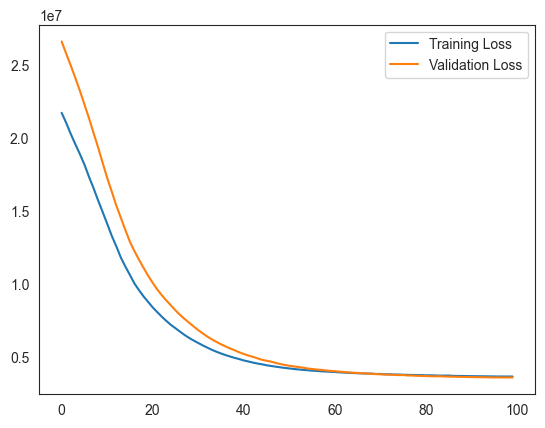

In [128]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [129]:
# train data에 대한 예측 값
AE_train_pred = AE.predict(train_X)

# 실제 값과 예측 값 사이의 차이인 MSE값을 reconstruction error로 정의 -> Novelty Score
train_mse = np.mean(np.power(train_X - AE_train_pred, 2), axis=1)
train_mse = pd.DataFrame({'Reconstruction_error': train_mse})
train_mse

14/14 [==============================] - 0s 846us/step


,Reconstruction_error
0,1.641658e+05
1,4.884040e+05
3,1.677801e+06
4,4.329076e+06
5,2.887932e+05
...,...
828,4.329067e+06
829,1.819930e+05
830,4.329100e+06
833,4.329097e+06


In [142]:
# train 데이터에 대한 novelty score 기준 상위 10% 의 값을 임계치로 설정
AE_thresh = np.percentile(sorted(train_mse['Reconstruction_error']), 50)
AE_thresh

4329075.605665141

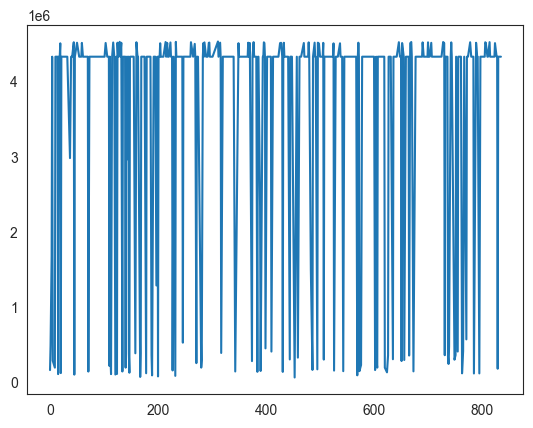

In [143]:
plt.plot(train_mse)

In [144]:
# test data에 대한 예측 값
AE_test_pred = AE.predict(test_X)

# 실제 값과 예측 값 사이의 차이인 MSE값을 reconstruction error로 정의
test_mse = np.mean(np.power(test_X - AE_test_pred, 2), axis=1)
test_mse

13/13 [==============================] - 0s 1ms/step


341    4.329076e+06
831    4.329075e+06
96     4.329075e+06
451    4.516805e+06
176    4.329076e+06
           ...     
812    4.329068e+06
822    4.329069e+06
825    4.329091e+06
836    4.329075e+06
837    4.329075e+06
Length: 404, dtype: float64

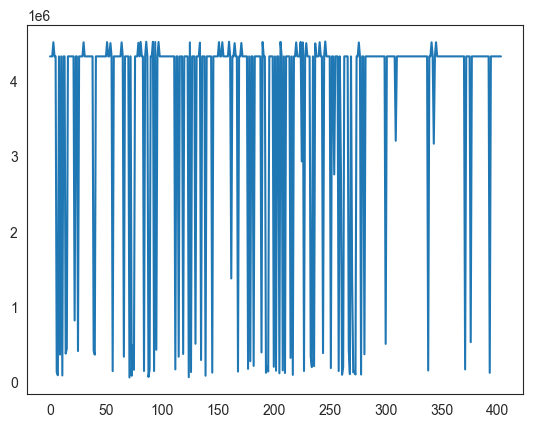

In [145]:
plt.plot(test_mse.values)

In [146]:
# classifier
# AE_thresh 기준, test_mse 값이 더 크면 이상(1), 작으면 정상(0)으로 분류
AE_test_df = []

def novelty_classifier(novelty_score):
    for i in range(len(novelty_score)):
        if novelty_score[i] > AE_thresh:
            AE_test_df.append(1)
        else:
            AE_test_df.append(0)

novelty_classifier(test_mse.values)

accuracy:  0.3712871287128713
recall:  0.228
precision:  0.319
f1-score:  0.266


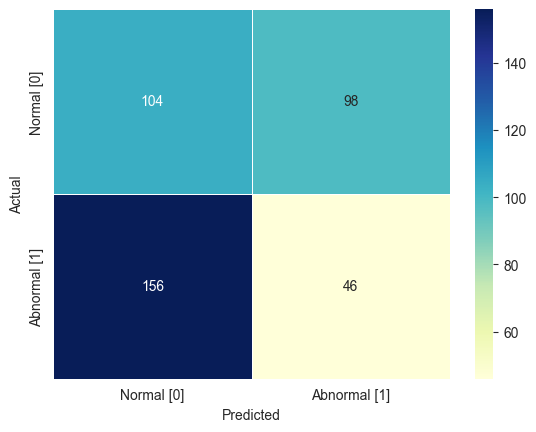

In [147]:
# Confusion matrix 출력 및 모델 성능 평가
con_mat = confusion_matrix(test_y, AE_test_df) #confusion_matrix 함수 실행

sns.heatmap(pd.DataFrame(con_mat, columns = ['Predicted', 'Actual']),
            xticklabels=['Normal [0]', 'Abnormal [1]'], 
            yticklabels=['Normal [0]', 'Abnormal [1]'], 
            annot=True, fmt="d", linewidths=.5, cmap="YlGnBu")
plt.ylabel('Actual')
plt.xlabel('Predicted')

print("accuracy: ", accuracy_score(test_y, AE_test_df))
print("recall: ", round(recall_score(test_y, AE_test_df),3))
print("precision: ", round(precision_score(test_y, AE_test_df),3))
print("f1-score: ", round(f1_score(test_y, AE_test_df),3))